In [45]:
# !pip install git+https://github.com/tensorflow/examples.git
# !pip install -U tensorflow

In [1]:
import os
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt
from tensorflow_examples.models.pix2pix import pix2pix

In [2]:
images_path_dir = os.path.join("./data/images", "images")
annotations_path_dir = os.path.join("./data/annotations", "annotations")

train_list_file = os.path.join(annotations_path_dir, "trainval.txt")
test_list_file = os.path.join(annotations_path_dir, "test.txt")

BATCH_SIZE = 64
BUFFER_SIZE = 1000
OUTPUT_CHANNELS = 3
DROPOUT_RATE = 0.4

IMG_WIDTH = 128
IMG_HEIGHT = 128

In [3]:
def data_generator(file_path):
    with tf.io.gfile.GFile(file_path, "r") as images_list:
        for line in images_list:
            image_name, label, species, _ = line.strip().split(" ")

            trimaps_dir_path = os.path.join(annotations_path_dir, "trimaps")

            trimap_name = image_name + ".png"
            image_name += ".jpg"
            label = int(label) - 1
            species = int(species) - 1

            record = {
                "image": os.path.join(images_path_dir, image_name),
                "label": int(label),
                "species": species,
                "file_name": image_name,
                "segmentation_mask": os.path.join(trimaps_dir_path, trimap_name)
            }
            
            yield os.path.join(images_path_dir, image_name), os.path.join(trimaps_dir_path, trimap_name)

In [4]:
train_ds = tf.data.Dataset.from_generator(data_generator, output_types=(tf.string, tf.string), args=[train_list_file])
test_ds = tf.data.Dataset.from_generator(data_generator, output_types=(tf.string, tf.string), args=[test_list_file])

In [5]:
def normalize(input_image, input_mask):
    input_image = tf.image.per_image_standardization(input_image)
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image(img_path, mask_path):
    input_image = tf.io.read_file(img_path)
    input_image = tf.image.decode_jpeg(input_image, channels = 3)
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = tf.image.resize(input_image, (IMG_HEIGHT, IMG_WIDTH))
    
    input_mask = tf.io.read_file(mask_path)
    input_mask = tf.image.decode_png(input_mask, channels = 1)
    input_mask = tf.image.resize(input_mask, (IMG_HEIGHT, IMG_WIDTH))
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

train = train_ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_ds.map(load_image)

train

W0512 19:14:36.628870 140736017953664 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/image_ops_impl.py:1518: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


<DatasetV1Adapter shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>

In [6]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [7]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

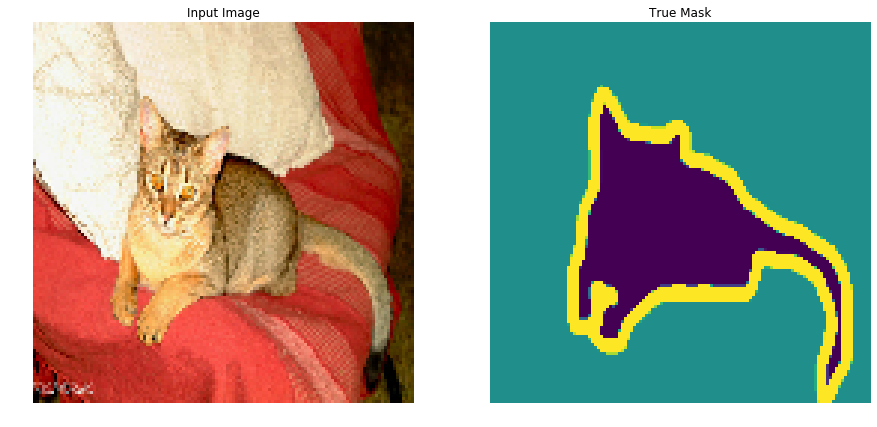

In [8]:
for image, mask in train.take(4):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [11]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

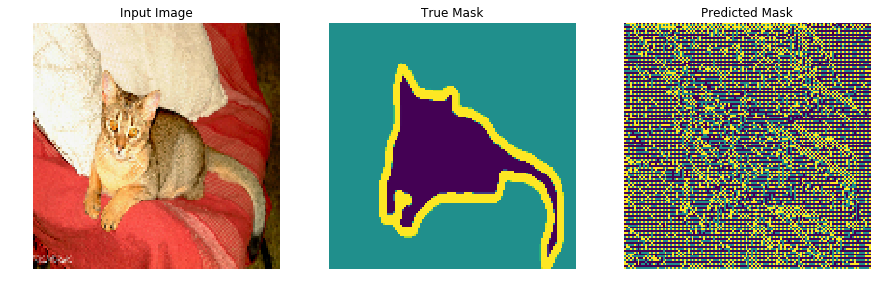

In [12]:
show_predictions()

In [13]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

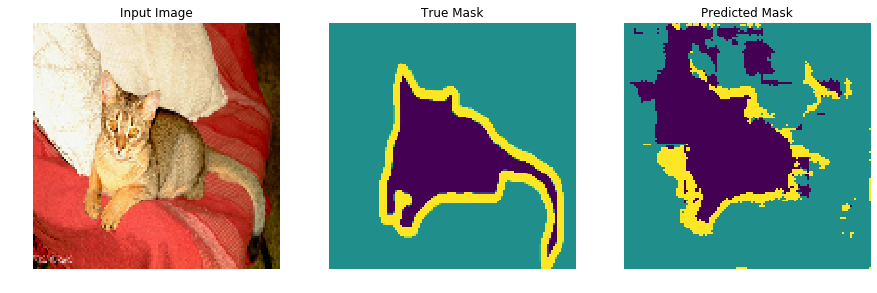


Sample Prediction after epoch 20

57/57 [==============================] - 201s 4s/step - loss: 0.1483 - accuracy: 0.9330


In [14]:
EPOCHS = 5
EPOCHS = 20

model_history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=57, callbacks=[DisplayCallback()])

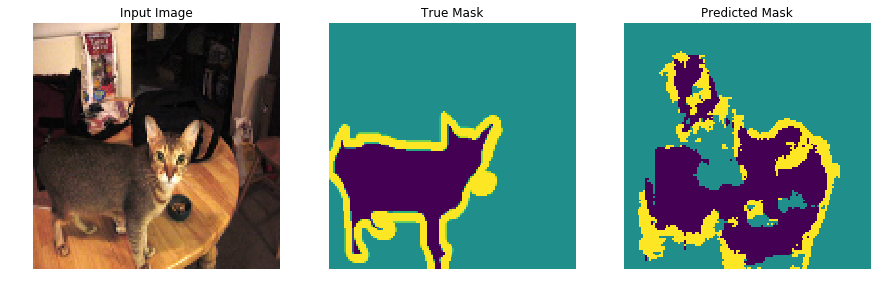

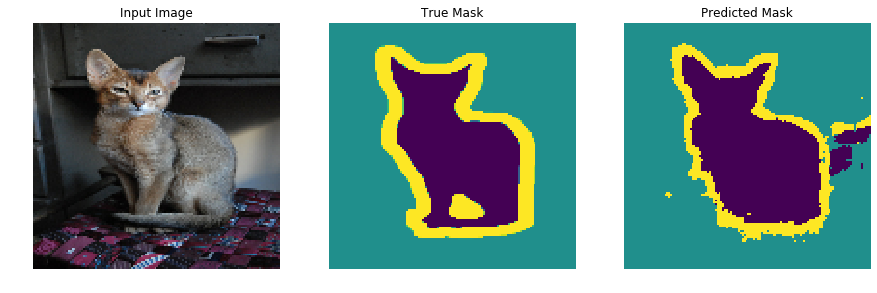

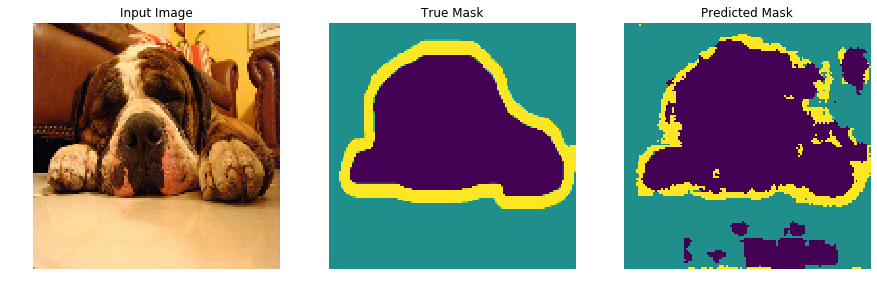

In [15]:
show_predictions(test_dataset, 3)